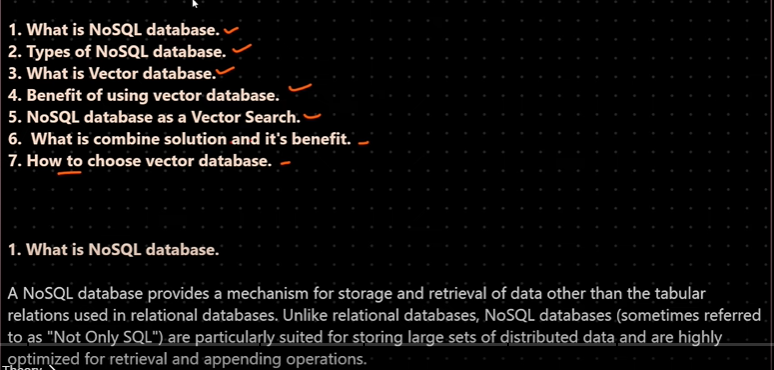

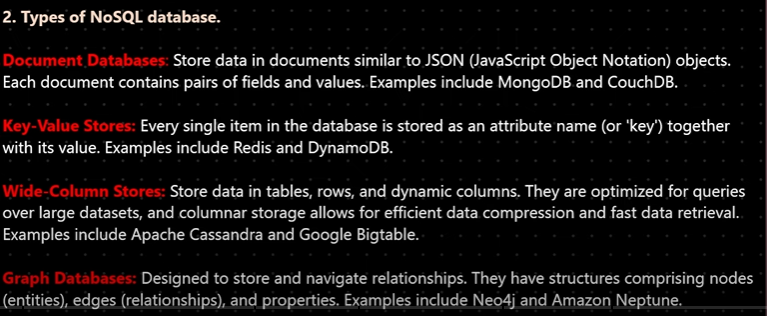

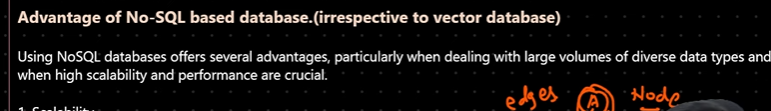

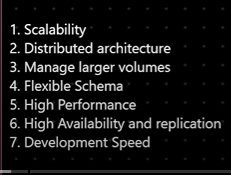

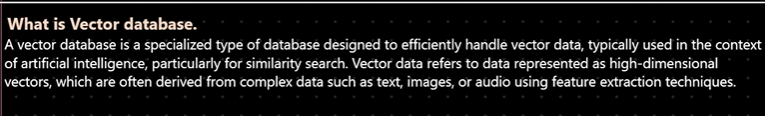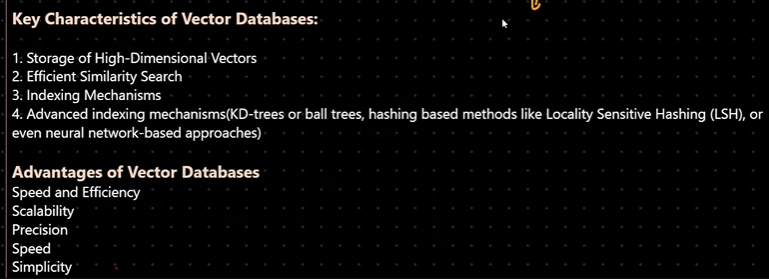

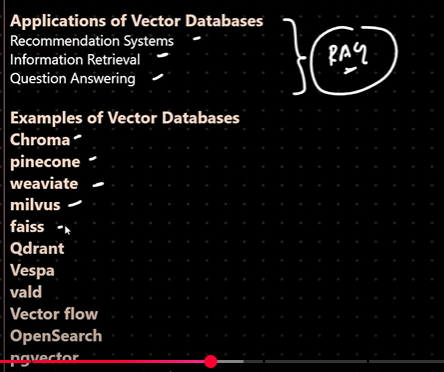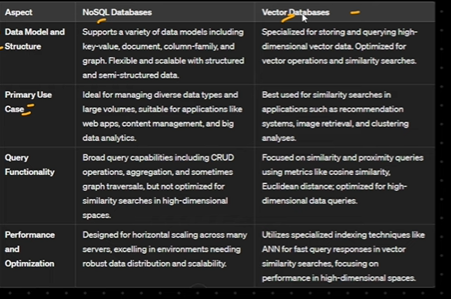

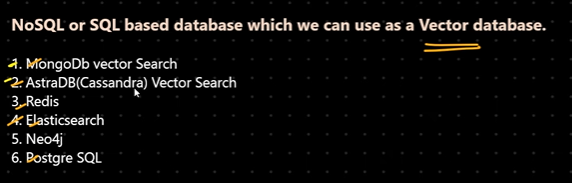

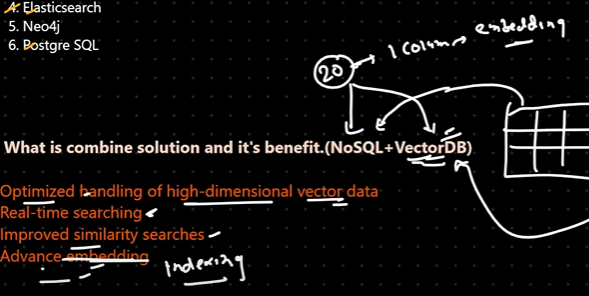

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
mongo_uri = os.getenv('MONGO_ATLAS_URI')
pinecone_api_key = os.getenv('PINECONE_API_KEY')

In [2]:
from pymongo.mongo_client import MongoClient
client = MongoClient(mongo_uri)
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [3]:
client

MongoClient(host=['cluster01-shard-00-00.h2shv.mongodb.net:27017', 'cluster01-shard-00-01.h2shv.mongodb.net:27017', 'cluster01-shard-00-02.h2shv.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-a4693r-shard-0', tls=True)

In [4]:

db=client["genai"]

In [37]:
collection=db["movies"] # no collection shows in atlas until atleast 1 data is added


In [6]:
from pinecone import Pinecone, ServerlessSpec

d:\a27_YEARS_OLD\multimodal_rag\venv\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [7]:
pc = Pinecone(api_key=pinecone_api_key)

In [8]:
pc

In [10]:
index_name = "mongo"

if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=1024, # Replace with your model dimensions
        metric="cosine", # Replace with your model metric
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        ) 
    )

In [15]:
# Target the index where you'll store the vector embeddings
index = pc.Index(index_name)

In [13]:
import time

In [11]:
# Wait for the index to be ready
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

In [14]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
# embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') # vector dimension of 384.

In [38]:
# from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("thenlper/gte-large") #vector dimension of 1024.

In [39]:
# open up change stream cursor
cursor = collection.watch(full_document='updateLookup')
print("Change stream is now open.")
while True:
    change = next(cursor)
    # If a new document is inserted into the collection, replicate its vector in Pinecone
    if change['operationType'] == 'insert':
      document = change['fullDocument']
      # convert the document's name into an embedding
      vector = embedding_model.encode(document['fullplot'])
      # Ensure the vector is a flat list of floats (and possibly convert to float64)
      vector = vector.tolist()  # Convert from numpy array to list
      vector = [float(x) for x in vector]  # Convert elements to float (usually float64)
      # Prepare the data for Pinecone upsert, which requires a tuple of (id, vector)
      # Assuming 'document['_id']' is the unique ID for the upsert operation
      upsert_data = (str(document['_id']), vector)
      # Insert into Pinecone
      index.upsert([upsert_data])  # Note that upsert_data is enclosed in a list

    elif change['operationType'] == 'update':
      document = change['fullDocument']
      document_id = document['_id']
      updated_fields = change['updateDescription']['updatedFields']

      # if the change is in the name field, generate the embedding and insert
      if updated_fields.get('fullplot'):
        vector = embedding_model.encode(updated_fields['fullplot'])
        upsert_data = (str(document_id), vector)
        # Insert into Pinecone
        index.upsert([upsert_data])  # Note that upsert_data is enclosed in a list

        #pinecone.upsert(index_name="myindex", data=vector, ids=[str(document_id)])

    # If a document is deleted from the collection, remove its vector from Pinecone
    elif change['operationType'] == 'delete':
      index.delete(ids=[str(change['documentKey']['_id'])])

Change stream is now open.


KeyboardInterrupt: 